<a href="https://colab.research.google.com/github/gracchen/bionics-lab-hand-plots/blob/main/plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [1]:
from google.colab import drive
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import minmax_scale

drive.mount('/content/drive', force_remount=True)
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

Mounted at /content/drive


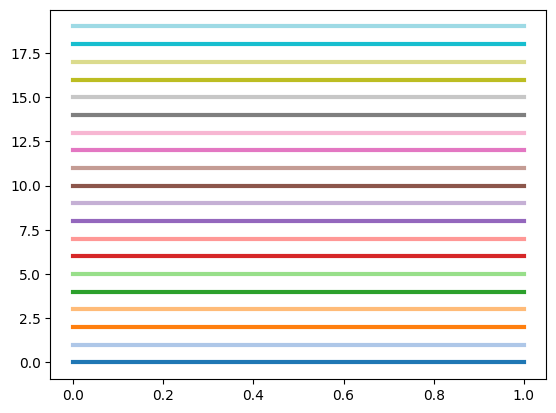

In [2]:
dir = '/content/drive/My Drive/Bionics Lab Research/Grace/'

testnames = ["Massfingerflexion", "Massfingerextension", "Hookgrasp", "Thumbadduction",  "Pincergrasp", "Cylindricalgrasp", "Sphericalgrasp"]
hands = ['Right', 'Left']
axes = ['x', 'y', 'z']
fingers = ['Index01', 'Index02','Thumb01']

degree_cols = ['Index01x', 'Index01y', 'Index01z', 'Index02x', 'Index02y', 'Index02z','Thumb01x', 'Thumb01y', 'Thumb01z']
force_cols = [' hook', ' paper', ' pencilThumb',' pencilFinger',' bottleVert', ' bottleRadial',' sphereThumb', ' sphereF_L1', ' sphereF_L2', ' sphereF_M', ' sphereF_R2', ' sphereF_R1']
dist_cols = ['Hand_pos—ThumbCMC_dist', 'Hand_pos—ThumbMCP_dist', 'Hand_pos—IndexMCP_dist', 'Hand_pos—IndexPIP_dist', 'ThumbMCP—IndexMCP_dist', 'ThumbMCP—IndexPIP_dist', 'Hand_pos—IndexPIP_dist', 'Hand_pos—IndexDIP_dist', 'ThumbMCP—IndexDIP_dist']
ratio_cols = ['Thumb_Hand_dist_ratio', 'Hand_Index1-2_dist_ratio', 'Thumb_Index1-2_dist_ratio', 'Hand_Index2-3_dist_ratio', 'Thumb_Index2-3_dist_ratio']
og_cols_for_ratio = [name + axis for name in ['Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'IndexDIP'] for axis in axes]
og_cols = degree_cols + force_cols + og_cols_for_ratio
new_cols = dist_cols + ratio_cols
used_cols = degree_cols + force_cols + new_cols

data_path = dir + 'data/7-18-2024 new joint data/AK_score2_thumb_open (both hands)/'
test_to_force = [['Thumb01x'], ['Thumb01x'], [force_cols[0]], [force_cols[1]], [force_cols[2],force_cols[3]], [force_cols[4],force_cols[5]], force_cols[6:]]

today_date = datetime.today().strftime("%-m-%-d-%Y")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
import matplotlib.pyplot as plt
import numpy as np

# Number of colors you want
num_colors = 20

# Generate a list of colors using a colormap
cmap = plt.get_cmap('tab20')  # 'tab20' is a colormap with 20 distinct colors
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]

# Example of using the generated colors
for i, color in enumerate(colors):
    plt.plot([0, 1], [i, i], color=color, lw=3)
plt.show()

In [3]:
test_to_force

[['Thumb01x'],
 ['Thumb01x'],
 [' hook'],
 [' paper'],
 [' pencilThumb', ' pencilFinger'],
 [' bottleVert', ' bottleRadial'],
 [' sphereThumb',
  ' sphereF_L1',
  ' sphereF_L2',
  ' sphereF_M',
  ' sphereF_R2',
  ' sphereF_R1']]

# Four-way Dist Plots

## helper & grapher

In [4]:
def mean_smooth(x, y, window_size=15):
    if window_size == 0:
      return y
    # Pad the data at both ends with the first and last values repeated
    padded_y = np.pad(y, (window_size//2, window_size-1-window_size//2), mode='edge')
    # Calculate moving average using convolution
    weights = np.ones(window_size) / window_size
    return np.convolve(padded_y, weights, mode='valid')

In [5]:
# smoothen and plot:

def smooth_data(MotionData, col_name, normalize=False, interpolate=True):
    """
    Takes the file dataframe and desired column to smooth (i.e. thumb01x)
    iterates through each element of the column (angle data) and smooths any
    jumps in the data with a constant being the difference between before and
    after the jump. Comment out the second last line to disable normalizing.
    """
    if col_name not in MotionData.columns and col_name in force_cols:
        #print(f"Column '{col_name}' not found in the DataFrame. Skipping.")
        return None, None  # Return the original DataFrame if the column is missing

    data = MotionData[col_name].copy()  # Create a copy of the column data

    data -= data[0]

    i = 1
    ct_neg = 0
    while i < len(data):
      if data[i] < 0:
        ct_neg = ct_neg + 1
      if abs(data[i-1] - data[i]) > 10:  # Jump detected
        constant = data[i-1] - data[i]
        data[i:] += constant
      i += 1

    flipped = data
    if 'thumb' in col_name.lower() and col_name in degree_cols:
      if (ct_neg > 0.6*len(data)):
        flipped = data * -1 # flip data
        print(f"flipping {col_name} because {ct_neg}/{len(data)} > 60%")
      #else:
        #print(f"NOT flipping {col_name} because {ct_neg}/{len(data)} <= 60%")

    return flipped, data
    #MotionData[col_name] = data  # Update the column in the original DataFrame

def smooth_ratio(MotionData, col_name, normalize=False, interpolate=True):
    """
    Takes the file dataframe and desired column to smooth (i.e. thumb01x)
    iterates through each element of the column (angle data) and smooths any
    jumps in the data with a constant being the difference between before and
    after the jump. Comment out the second last line to disable normalizing.
    """
    data = MotionData[col_name].copy()  # Create a copy of the column data
    i = 1
    while i < len(data):
      if abs(data[i-1] - data[i]) > 0.005:  # Jump detected
        constant = data[i-1] - data[i]
        data[i:] += constant
      i += 1

    if normalize: data -= data[0]
    MotionData[col_name] = data  # Update the column in the original DataFrame

def smooth_file(file_name, cols = None, normalize=False):
    """
    repeats smoothening for all desired columns (3 axes of 2 measured fingers)
    """
    #print(f"reading {data_path+file_name}")
    MotionData = pd.read_csv(data_path+file_name)
    if cols is None:
      for finger in fingers:
        for axis in axes:
          smooth_data(MotionData, finger+'01'+axis, normalize)
    else:
      for col in cols:
          smooth_data(MotionData, col, normalize)
    return MotionData

# general func to compute dist(base, joint2) / dist(base, joint1)
def compute_ratio(file, base, joint1, joint2, output):
  if isinstance(file, str):
    df = pd.read_csv(data_path+file)
  else: df = file
  shape = df['Handx'].shape
  for joint in [base, joint1, joint2]:
    for axis in axes:
      smooth_data(df, joint+axis)

  base_dfs = [df[base+axis] for axis in axes]
  joint1_dfs = [df[joint1+axis] for axis in axes]
  joint2_dfs = [df[joint2+axis] for axis in axes]

  dist1 = np.sqrt((joint1_dfs[0] - base_dfs[0])**2 + (joint1_dfs[1] - base_dfs[1])**2 + (joint1_dfs[2] - base_dfs[2])**2)
  dist2 = np.sqrt((joint2_dfs[0] - base_dfs[0])**2 + (joint2_dfs[1] - base_dfs[1])**2 + (joint2_dfs[2] - base_dfs[2])**2)

  base = base[0:-1] if base[-1] == '_' else base
  joint1 = joint1[0:-1] if joint1[-1] == '_' else joint1
  joint2 = joint2[0:-1] if joint2[-1] == '_' else joint2

  df[base + "—" + joint1 + "_dist"] = dist1
  smooth_ratio(df, base + "—" + joint1 + "_dist")
  df[base + "—" + joint2 + "_dist"] = dist2
  smooth_ratio(df, base + "—" + joint2 + "_dist")
  df[output] = np.where(dist1 != 0, dist2 / dist1, 0)
  smooth_ratio(df, output)
  #print(f"adding columns {base + '—' + joint1 + '_dist'} and {base + '—' + joint2 + '_dist'} ")
  return df, (base + "—" + joint1 + "_dist"), (base + "—" + joint2 + "_dist")

In [6]:
def no_scroll():
    # avoid scrolling if displaying one plot:
    from google.colab import output
    output.no_vertical_scroll()

In [7]:
def graph_files(files, files_untrimmed, deg_min_max, ratio_min_max, dist_min_max, save_path = None, output_name = None, normalize = True, trim=True, hide_plot=False):
  """
  generates smoothened plots of x,y,z for one csv file given path, test name,
  hand (Left or Right). If save_path defined, will save the plot as image in
  plots folder, otherwise will display it.
  """
  is_both = False
  num_trials = sum('Left' in file for file in files.keys())
  #print(f"num_trials={num_trials} Left, {sum('Right' in file for file in files.keys())} Right")

  test_name = -1
  for i, t in enumerate(testnames):
    if len(files.keys()) == 0:
      print(f"OOPS,!!")
    if t in next(iter(files.keys())):
      test_name = t
      test_no = i+1
  if test_name == -1: raise Exception("test name not found")
  if 'Right' in next(iter(files.keys())): hand = 'Right'
  else: hand = 'Left'

  dfs = files.values() # retrieve all processed dfs of the filenames
  dfs_untrimmed = files_untrimmed.values() # retrieve all processed dfs of the filenames

  fig, subplts = plt.subplots(9, 4, figsize=(9, 22))
  #fig, ((ax1, ax2, ax3, a),(ax4, ax5, ax6, b),(ax19, ax20, ax21, c),(ax7, ax8, ax9, d),(ax10, ax11, ax12, e),(ax13, ax14, ax15, f),(ax22,ax23,ax24, g),(ax16,ax17,ax18, ax25)) \
  #= plt.subplots(8, 4, figsize=(10, 18)) # increased height
  if output_name is None: plt.suptitle(str(test_no) + '. ' + test_name + ' ' + hand + ' Hand', fontsize='xx-large')
  else:
    plt.suptitle(output_name, fontsize='xx-large')
    if 'Both' in output_name or 'both' in output_name:
      is_both = True

  fig.tight_layout()
  fig.subplots_adjust(top=0.94)
  plt.subplots_adjust(hspace=0.5)
  plt.subplots_adjust(wspace=1.2)

  # degrees
  for finger, plts in zip(fingers, [subplts[0],subplts[1], subplts[2]]):
    for axis, plt_id in zip(axes, plts):
      for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
        label = 'L' if is_both and i < num_trials else 'R'
        color = 'blue' if label == 'L' else 'green'
        plt_id.plot(df['Timestamp'], df[finger + axis], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color)
        plt_id.plot(df['Timestamp'], df_untrimmed[finger + axis], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color, alpha=0.2)
      plt_id.set(xlabel ='time', ylabel = 'degrees')
      plt_id.set_title(finger + ' ' + axis + '-axis')

  # Plot sum of x, y, z for each joint
  for finger, plt_id in zip(fingers, [subplts[0][-1],subplts[1][-1], subplts[2][-1]]):
    for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
      label = 'L' if is_both and i < num_trials else 'R'
      color = 'blue' if label == 'L' else 'green'
      abs_sum= np.abs(df[[finger + 'x', finger + 'y', finger + 'z']]).sum(axis=1)
      abs_sum_untrimmed= np.abs(df_untrimmed[[finger + 'x', finger + 'y', finger + 'z']]).sum(axis=1)
      plt_id.plot(df['Timestamp'], abs_sum, label=str(i + 1) if not is_both else label, color=colors[i] if not is_both else color)
      plt_id.plot(df['Timestamp'], abs_sum_untrimmed, label=str(i + 1) if not is_both else label, color=colors[i] if not is_both else color, alpha=0.2)
    plt_id.set(xlabel='time', ylabel='Sum of x, y, z')
    plt_id.set_title('Sum of x, y, z')

  # ratios
  for names, plts in zip([['Hand_pos—ThumbCMC_dist','Hand_pos—ThumbMCP_dist','Thumb_Hand_dist_ratio'], \
    ['Hand_pos—IndexMCP_dist','Hand_pos—IndexPIP_dist','Hand_Index1-2_dist_ratio'], \
    ['ThumbMCP—IndexMCP_dist', 'ThumbMCP—IndexPIP_dist','Thumb_Index1-2_dist_ratio'],\
    #['IndexMCP—IndexPIP_dist', 'IndexMCP—IndexDIP_dist','Index1_Index2-3_dist_ratio'], \
    ['Hand_pos—IndexPIP_dist', 'Hand_pos—IndexDIP_dist','Hand_Index2-3_dist_ratio'],\
    ['ThumbMCP—IndexPIP_dist', 'ThumbMCP—IndexDIP_dist','Thumb_Index2-3_dist_ratio']], \
      [subplts[3], subplts[4], subplts[5], subplts[6], subplts[7]]):
    for ratio,plt_id,ylabel in zip(names, plts, ['jointA','jointB','ratio']):
      for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
        label = 'L' if is_both and i < num_trials else 'R'
        color = 'blue' if label == 'L' else 'green'
        plt_id.plot(df['Timestamp'], df[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color)
        plt_id.plot(df['Timestamp'], df_untrimmed[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color, alpha=0.2)
      plt_id.set(xlabel ='time', ylabel = ylabel)
      plt_id.set_title(ratio)

  # join degree rows
  degree_axes = np.concatenate((subplts[0][:-1], subplts[1][:-1], subplts[2][:-1]))
  #for ax1, ax2 in zip(degree_axes[1:],degree_axes[0:-1]): ax1.sharey(ax2)
  for ax in degree_axes:
    ax.set_ylim([deg_min_max[0], deg_min_max[1]])

  for i in range(3,8):
    subplts[i][2].set_ylim([ratio_min_max[0], ratio_min_max[1]]) # join ratio rows
    subplts[i][0].set_ylim([dist_min_max[0], dist_min_max[1]]) #dist rows
    subplts[i][1].set_ylim([dist_min_max[0], dist_min_max[1]]) #dist rows

  # join force rows
  for i in range(3): subplts[-1][i].sharey(subplts[-1][3])

  # force sensor plot
  invert_axis =False
  if test_no == 3 or test_no == 4: #hook, thumb
    ratio = force_cols[test_no-3]
    plt_id = subplts[-1][0]
    ylabel = 'force data'
    for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
      label = 'L' if is_both and i < num_trials else 'R'
      color = 'blue' if label == 'L' else 'green'
      plt_id.plot(df['Timestamp'], df[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color)
      plt_id.plot(df['Timestamp'], df_untrimmed[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color, alpha=0.2)
    plt_id.set(xlabel ='time', ylabel = ylabel)
    plt_id.set_title(ratio)
    if invert_axis: plt_id.invert_yaxis()
  elif test_no == 7: #sphere
    start_index = (test_no-4)*2
    for ratio, plt_id in zip(force_cols[start_index:], np.concatenate([subplts[-1], subplts[-2][3:], subplts[-3][3:]])):
      ylabel = 'force data'
      for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
        label = 'L' if is_both and i < num_trials else 'R'
        color = 'blue' if label == 'L' else 'green'
        plt_id.plot(df['Timestamp'], df[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color)
        plt_id.plot(df['Timestamp'], df_untrimmed[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color, alpha=0.2)
      plt_id.set(xlabel ='time', ylabel = ylabel)
      plt_id.set_title(ratio)
      if invert_axis: plt_id.invert_yaxis()
  elif test_no > 2: #pencil, cylinder
    start_index = (test_no-4)*2
    for ratio, plt_id in zip(force_cols[start_index:start_index+2], subplts[-1]):
      ylabel = 'force data'
      for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
        label = 'L' if is_both and i < num_trials else 'R'
        color = 'blue' if label == 'L' else 'green'
        plt_id.plot(df['Timestamp'], df[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color)
        plt_id.plot(df['Timestamp'], df_untrimmed[ratio], label=str(i+1) if not is_both else label, color=colors[i] if not is_both else color, alpha=0.2)
      plt_id.set(xlabel ='time', ylabel = ylabel)
      plt_id.set_title(ratio)
      if invert_axis: plt_id.invert_yaxis()

  # adjust legend and visibility
  custom_lines = [Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='green', lw=2)]
  for row in subplts:
    for ax in row:
      if ax.has_data():
        if (is_both): ax.legend(custom_lines, ['L', 'R'], fontsize='x-small', bbox_to_anchor=(1.05, 1.0), loc='upper left')
        else: ax.legend(fontsize='x-small', bbox_to_anchor=(1.05, 1.0), loc='upper left')
      else: ax.axis('off')

  # save the image:
  if save_path is not None:
    if output_name is None:
      file_prefix = os.path.splitext(next(iter(files.keys())))[0] # Get the filename without extension
      save_file_path = os.path.join(save_path, f"{file_prefix}_{'relative' if normalize else 'absolute'}.png")
    else:
      save_file_path = os.path.join(save_path, f"{output_name}.png")

    os.makedirs(save_path, exist_ok=True)
    print(f"saving to {save_file_path}")
    plt_id.figure.savefig(save_file_path)

  if hide_plot: plt.close()
  else: plt.show()

#print("HI")
#graph_files('LeftHand_07_03_2024_11_30_12Massfingerflexion_1.csv', trim=False)
#graph_files('LeftHand_07_03_2024_11_30_12Massfingerflexion_1.csv')
#graph_files('RightHand_05_18_2024_14_31_08_SphericalGraspp.csv', trim=False)
#graph_files('RightHand_05_18_2024_14_31_08_SphericalGraspp.csv')


In [8]:
def graph_all_scores(score2_files, score1_files, score0_files, score2_files_untrimmed, score1_files_untrimmed, score0_files_untrimmed, hand, deg_min_max, save_path, output_name, normalize = True, trim=True, hide_plot=False):
  """
  generates smoothened plots of x,y,z for one csv file given path, test name,
  hand (Left or Right). If save_path defined, will save the plot as image in
  plots folder, otherwise will display it.
  """
  #dfs = files.values() # retrieve all processed dfs of the filenames

  all_dfs = {
        2: (score2_files.values(),score2_files_untrimmed.values()),
        1: (score1_files.values(),score1_files_untrimmed.values()),
        0: (score0_files.values(),score0_files_untrimmed.values()),
    }

  num_trials = {
        2: sum('Left' in file for file in score2_files.keys()),
        1: sum('Left' in file for file in score1_files.keys()),
        0: sum('Left' in file for file in score0_files.keys())
    }

  is_both = True if 'both' in hand.lower() else False

  test_name = -1
  for i, t in enumerate(testnames):
    if t in next(iter(score2_files.keys())):
      test_name = t
      test_no = i+1
  if test_name == -1: raise Exception("test name not found")

  fig, subplts = plt.subplots(9, 3, figsize=(7, 18))

  # column and row labels:
  cols = ['Score {}'.format(col) for col in range(0,3)]
  rows = degree_cols
  for ax, col in zip(subplts[0], cols):
      ax.set_title(col)

  for ax, row in zip(subplts[:,0], rows):
      ax.set_ylabel(row, rotation=0, size='large')

  # set main title and image name:
  if output_name is None: plt.suptitle(str(test_no) + '. ' + test_name + ' ' + hand + ' Hand', fontsize='xx-large')
  else: plt.suptitle(output_name, fontsize='xx-large')

  fig.tight_layout()
  fig.subplots_adjust(top=0.94)
  plt.subplots_adjust(hspace=0.3)
  plt.subplots_adjust(wspace=1)

  # degrees
  for score in range(2,-1,-1):
    for degree_col, j in zip(degree_cols, range(9)):
      dfs = all_dfs[score][0]  # Access scoreX_files.values()
      dfs_untrimmed = all_dfs[score][1]  # Access scoreX_files_untrimmed.values()
      for i, (df, df_untrimmed) in enumerate(zip(dfs, dfs_untrimmed)):
        label = 'L' if is_both and i < num_trials[score] else 'R'
        color = 'blue' if label == 'L' else 'green'
        subplts[j][score].plot(df['Timestamp'], df[degree_col], label=str(i+1) if not is_both else label, color=None if not is_both else color)
        subplts[j][score].plot(df['Timestamp'], df_untrimmed[degree_col], label=str(i+1) if not is_both else label, color=None if not is_both else color, alpha=0.2)
        #subplts[j][score].set(ylabel = degree_col)
        subplts[j][score].set_title('Score ' + str(score))

  # join degree rows
  for i in range(9):
    for j in range(3):
      subplts[i][j].set_ylim([deg_min_max[0], deg_min_max[1]])

  # adjust legend and visibility
  custom_lines = [Line2D([0], [0], color='blue', lw=2), Line2D([0], [0], color='green', lw=2)]
  for row in subplts:
    for ax in row:
      if ax.has_data():
        if (is_both): ax.legend(custom_lines, ['L', 'R'], fontsize='x-small', bbox_to_anchor=(1.05, 1.0), loc='upper left')
        else: ax.legend(fontsize='x-small', bbox_to_anchor=(1.05, 1.0), loc='upper left')
      else: ax.axis('off')

  # save the image:
  if save_path is not None:
    save_file_path = os.path.join(save_path, f"{output_name}.png")
    os.makedirs(save_path, exist_ok=True)
    print(f"saving to {save_file_path}")
    fig.savefig(save_file_path)

  if hide_plot: plt.close()
  else: plt.show()

#print("HI")
#graph_files('LeftHand_07_03_2024_11_30_12Massfingerflexion_1.csv', trim=False)
#graph_files('LeftHand_07_03_2024_11_30_12Massfingerflexion_1.csv')
#graph_files('RightHand_05_18_2024_14_31_08_SphericalGraspp.csv', trim=False)
#graph_files('RightHand_05_18_2024_14_31_08_SphericalGraspp.csv')


## process file

In [21]:
def process_file(path, threshold_a, threshold_b,trim=True, window_size=[10,10]):
  df = pd.read_csv(path)
  flipped = {x:None for x in og_cols} # store flipped cols to apply later

  #interpolation setup
  interp_prefft_duration = 2
  interp_prefft_step = 0.01
  interp_data = pd.DataFrame()
  interp_prefft_time = np.linspace(0, interp_prefft_duration, num=int(interp_prefft_duration/interp_prefft_step)+1)

  for col_name in og_cols:
    flip, unflipped = smooth_data(df, col_name, normalize=False) #only flips thumb degrees if mostly below zero
    if flip is not None:
      df[col_name] = unflipped  # Update the column in the original DataFrame
      flipped[col_name] = flip

  if testnames[0] in path: testno=0
  elif testnames[1] in path: testno=1
  elif testnames[2] in path: testno=2
  elif testnames[3] in path: testno=3
  elif testnames[4] in path: testno=4
  elif testnames[5] in path: testno=5
  elif testnames[6] in path: testno=6
  else: raise Exception("test name not found")

  isThumbAdduction = testnames[3] in path
  #print(f"{path} is {'' if isThumbAdduction else 'not'} thumbadduction")
  # smooth the degree column with biggest range

  df, _,_ = compute_ratio(df, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
  df, _,_ = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Hand_Index1-2_dist_ratio')
  df, _,_ = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Thumb_Index1-2_dist_ratio')
  #df, _,_ = compute_ratio(df, 'IndexMCP', 'IndexPIP', 'IndexDIP', 'Index1_Index2-3_dist_ratio')
  df, _,_ = compute_ratio(df, 'Hand_pos_', 'IndexPIP', 'IndexDIP', 'Hand_Index2-3_dist_ratio')
  df, _,_ = compute_ratio(df, 'ThumbMCP', 'IndexPIP', 'IndexDIP', 'Thumb_Index2-3_dist_ratio')

  # set timestamp min-max to 0 to 2 with sklearn
  df['Timestamp'] = minmax_scale(df[['Timestamp']], feature_range=(0, 2))

  # compute mean smoothed data cols and pick col to trim by max range of mean-smoothed degs
  deg_ranges = {col: df[col].max() - df[col].min() for col in degree_cols}
  picked_deg = max(deg_ranges, key=deg_ranges.get)
  df[picked_deg+'_mean_smooth'] = mean_smooth(df['Timestamp'], df[picked_deg], window_size=window_size[0])
  for f in test_to_force[testno]:
    df[f+'_mean_smooth'] = mean_smooth(df['Timestamp'], df[f], window_size=window_size[1])

  # 0. GET NORMALIZED UNTRIMMED VERSION
  df_untrimmed = df.copy(deep=True)
  for c in degree_cols + new_cols + test_to_force[testno]:
    if 'ratio' in c: df_untrimmed.loc[:, c] -= df_untrimmed[c].iloc[0] - 1 #normalize to 1
    else: df_untrimmed.loc[:, c] -= df_untrimmed[c].iloc[0]  # normalize to 0
  #interpolate:
  interp_data = pd.DataFrame()
  interp_data['Timestamp'] = interp_prefft_time
  for col in df_untrimmed: interp_data[col] = np.interp(interp_prefft_time, df_untrimmed['Timestamp'], df_untrimmed[col])
  df_untrimmed = interp_data

  # 0. apply flip to df after saving df_untrimmed
  for col_name, flip in zip(flipped.keys(),flipped.values()):
    if flip is not None: df[col_name] = flip

  # 1. interpolate mean smoothed data @ 0.01 = 100 cycles per second, at 2 sec
  interp_data = pd.DataFrame()
  interp_data['Timestamp'] = interp_prefft_time
  for col in df: interp_data[col] = np.interp(interp_prefft_time, df['Timestamp'], df[col])
  df = interp_data

  # 2. clip the data
  #def trimmer(smoothed_deg, smoothed_forces, threshold_a, threshold_b, isThumbAdduction=False, isForce=False):
  if (trim):
    start,end = trimmer(df['Timestamp'], df[picked_deg+'_mean_smooth'], [df[x+'_mean_smooth'] for x in test_to_force[testno]], threshold_a, threshold_b, window_size, isThumbAdduction, isForce=testno>=2)
    print(f"trim: {start}-{end} instead of 0-{len(df['Timestamp'])}")
    df = df.iloc[start:end]

  # set timestamp min-max to 0 to 2 with sklearn
  df['Timestamp'] = minmax_scale(df[['Timestamp']], feature_range=(0, 2))

  # 3. interpolate, 0.01 = 100 cycles per second, at 2 sec
  interp_data = pd.DataFrame()
  interp_data['Timestamp'] = interp_prefft_time

  for col_name in degree_cols + new_cols + test_to_force[testno]:
    interp_data[col_name] = np.interp(interp_prefft_time, df['Timestamp'], df[col_name])
    # normalize cols
    if 'ratio' in col_name: interp_data.loc[:, col_name] -= interp_data[col_name].iloc[0] - 1 #normalize to 1
    elif col_name in force_cols:
      if interp_data[col_name].iloc[0] >= 900:
        print(f"flipped {col_name} for file {path}")
        interp_data.loc[:, col_name] = -1 * interp_data[col_name] # flip the force col
        interp_data.loc[:, col_name] -= interp_data[col_name].iloc[0] # normalize to 0
    else: interp_data.loc[:, col_name] -= interp_data[col_name].iloc[0]  # normalize to 0

  #print(interp_data.columns)
  return interp_data, df_untrimmed, picked_deg

## trimmer (for batch plotter)

In [10]:
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

def trimmer(time, smoothed_deg, smoothed_forces, threshold_a, threshold_b, window_size=10, isThumbAdduction=False, isForce=False):
    min_trim_array_length = 10  # minimum no. of datapoints after trimming
    #print(type(window_size))
    def moving_average(arr, window_size):
        """Calculate the moving average with the given window size."""
        return np.convolve(arr, np.ones(window_size) / window_size, mode='valid')

    # CUT BEGINNING
    gradient = np.gradient(smoothed_deg, time)
    gradient_threshold_a = threshold_a * max(abs(max(gradient)), abs(min(gradient)))
    gradient_threshold_b = threshold_b[0] * max(abs(max(gradient)), abs(min(gradient)))
    print(f"threshold b: {gradient_threshold_b}")

    start_idx = 0
    if isThumbAdduction:
        for i in range(1, len(smoothed_deg) // 2):  # find index of local y peak at first half of data
            if abs(smoothed_deg[start_idx]) <= abs(smoothed_deg[i]):
                start_idx = i
    else:
        moving_avg_gradient = moving_average(abs(gradient), window_size[0])
        moving_avg_threshold_a = gradient_threshold_a
        for i in range(len(moving_avg_gradient)):
            if moving_avg_gradient[i] > moving_avg_threshold_a:
                start_idx = i
                break

    # CUT ENDING
    if isForce:
        latest_end_idx = 0
        for f in smoothed_forces:
            data_array = np.array(f)  # cut end based on first force plateau
            gradient = np.gradient(data_array, time)
            gradient_threshold_b = threshold_b[1] * max(abs(max(gradient)), abs(min(gradient)))
            print(f"threshold b for force: {gradient_threshold_b}")
            moving_avg_gradient = moving_average(abs(gradient), window_size[1])
            end_idx = len(moving_avg_gradient) // 2
            for i in range(len(moving_avg_gradient) - 1, -1, -1):
                if moving_avg_gradient[i] > gradient_threshold_b:
                    end_idx = i + window_size[1]  # Adjust for window size
                    latest_end_idx = max(latest_end_idx, end_idx)
                    break
        end_idx = latest_end_idx
    else:
        moving_avg_gradient = moving_average(abs(gradient), window_size[0])
        end_idx = len(smoothed_deg)
        for i in range(len(moving_avg_gradient) - 1, -1, -1):
            if moving_avg_gradient[i] > gradient_threshold_b:
                end_idx = i + window_size[0]  # Adjust for window size
                break

    # Ensure start_idx is less than end_idx
    if start_idx >= end_idx:
        return 0, len(smoothed_deg)

    return start_idx, end_idx + 1


In [17]:
# custom get_dfs for horiz vert sphere and thumb

# fetch and sort all filenames from a subfolder and put in dict with 'Right' and 'Left' info
def get_dfs2(subfolder, threshold_a, threshold_b, trim=True, window_size=[10,10]):
  # generate dfs
  data_path = dir + subfolder
  #print(data_path+'/')
  file_list = os.listdir(data_path)
  filenames_untrimmed = {}
  filenames_trimmed = {}
  for testname, testno in zip(testnames, range(0,len(testnames))):
    col_picked_count = {}
    filenames_untrimmed[testno] = {'Right': {}, 'Left': {}}
    filenames_trimmed[testno] = {'Right': {}, 'Left': {}}

    for filename in file_list:
      if 'meta' in filename or testname not in filename or not filename.endswith('.csv'):
        continue

      if 'touch' in filename.lower() or re.search(r'_T\d\.csv$', filename) is not None: # skip sensor touched
        continue

      hand = 'Left'
      if 'right' in filename.lower(): hand = 'Right'

      df, df_untrimmed, picked_col = process_file(data_path+'/'+filename,threshold_a, threshold_b,trim,window_size)

      filenames_trimmed[testno][hand][filename] = df
      filenames_untrimmed[testno][hand][filename] = df_untrimmed
      col_picked_count[picked_col] = (col_picked_count[picked_col]+1) if picked_col in col_picked_count else 1

    # sort col_picked_count by most counts first
    col_picked_count = dict(sorted(col_picked_count.items(), key=lambda item: item[1], reverse=True))
    print(f"\t{testname}:")
    print(f'\t{col_picked_count}')

  return filenames_trimmed, filenames_untrimmed

 ### score 2 vs score 1 vs score 0


In [22]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
import imageio
import re
from IPython.display import Image # Explicitly import Image
#no_scroll()
folder='data/8-04-2024 and 8-05-2024 data/'
hide_plot = True

for initials in ['AK','SN', 'SY', 'SM']:
  print(initials)
  subfolders = os.listdir(dir+folder+initials)
  print(f"subfolders for {initials} are {subfolders}")

  all_dicts = {}

  for subfolder in subfolders:
    pattern = re.compile(r'_Score(\d+)')
    score = int(pattern.search(subfolder).group(1))
    print(f"score of {subfolder} is {score}")

    filenames_trimmed, filenames_untrimmed = get_dfs2(folder+initials+'/'+subfolder, threshold_a=0.15, threshold_b=[0.15,0.15], trim=True, window_size=[10,10])

    all_dicts[score] = {'trimmed': filenames_trimmed, 'untrimmed': filenames_untrimmed}
    #all_dfs[score] = filenames[testno]['Left'].values()
    #num_trials[score] = sum('Left' in file for file in filenames[testno]['Left'].keys())

  #print(dict(filenames[1]['Right'], **filenames[1]['Left']).keys())
  output_folder = dir + 'tendency plots/' + str(today_date) + '/' + initials +'/'
  #output_folder = None
  #os.makedirs(output_folder, exist_ok=True)
  print(f'\toutput_folder: {output_folder}')

  # Initialize max and min values
  deg_min_max = [-100,100]
  ratio_min_max = [float('inf'),float('-inf')]
  dist_min_max = [float('inf'),float('-inf')]

  # Iterate through testnames and filenames
  for testno in range(len(testnames)):
    list_of_dfs = dict(all_dicts[2]['trimmed'][testno]['Left'], **all_dicts[2]['trimmed'][testno]['Right']).values()

    for df in list_of_dfs:
      for col in ratio_cols:
        ratio_min_max[0] = min(ratio_min_max[0], df[col].min())
        ratio_min_max[1] = max(ratio_min_max[1], df[col].max())
      for col in dist_cols:
        dist_min_max[0] = min(dist_min_max[0], df[col].min())
        dist_min_max[1] = max(dist_min_max[1], df[col].max())

  for testno in range(0,len(testnames)): #input is dict mapping file name to processed df of that file

    # all score graphs:
    graph_all_scores(all_dicts[2]['trimmed'][testno]['Left'], all_dicts[1]['trimmed'][testno]['Left'], all_dicts[0]['trimmed'][testno]['Left'], \
                     all_dicts[2]['untrimmed'][testno]['Left'], all_dicts[1]['untrimmed'][testno]['Left'], all_dicts[0]['untrimmed'][testno]['Left'], \
                     'Left', deg_min_max, output_folder, f"{testno+1}. {testnames[testno]} {initials} LeftHand trimmed Thumb-flipped", hide_plot=hide_plot)
    graph_all_scores(all_dicts[2]['trimmed'][testno]['Right'], all_dicts[1]['trimmed'][testno]['Right'], all_dicts[0]['trimmed'][testno]['Right'], \
                     all_dicts[2]['untrimmed'][testno]['Right'], all_dicts[1]['untrimmed'][testno]['Right'], all_dicts[0]['untrimmed'][testno]['Right'], \
                     'Right', deg_min_max, output_folder, f"{testno+1}. {testnames[testno]} {initials} RightHand trimmed Thumb-flipped", hide_plot=hide_plot)
    graph_all_scores(dict(all_dicts[2]['trimmed'][testno]['Left'], **all_dicts[2]['trimmed'][testno]['Right']), \
                     dict(all_dicts[1]['trimmed'][testno]['Left'], **all_dicts[1]['trimmed'][testno]['Right']), \
                     dict(all_dicts[0]['trimmed'][testno]['Left'], **all_dicts[0]['trimmed'][testno]['Right']), \
                     dict(all_dicts[2]['untrimmed'][testno]['Left'], **all_dicts[2]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[1]['untrimmed'][testno]['Left'], **all_dicts[1]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[0]['untrimmed'][testno]['Left'], **all_dicts[0]['untrimmed'][testno]['Right']), \
                     'Both', deg_min_max, output_folder, f"{testno+1}. {testnames[testno]} {initials} BothHands trimmed Thumb-flipped", hide_plot=hide_plot)

    graph_all_scores(all_dicts[2]['untrimmed'][testno]['Left'], all_dicts[1]['untrimmed'][testno]['Left'], all_dicts[0]['untrimmed'][testno]['Left'], \
                     all_dicts[2]['untrimmed'][testno]['Left'], all_dicts[1]['untrimmed'][testno]['Left'], all_dicts[0]['untrimmed'][testno]['Left'], \
                     'Left', deg_min_max, output_folder, f"{testno+1}. {testnames[testno]} {initials} LeftHand untrimmed unflipped", hide_plot=hide_plot)
    graph_all_scores(all_dicts[2]['untrimmed'][testno]['Right'], all_dicts[1]['untrimmed'][testno]['Right'], all_dicts[0]['untrimmed'][testno]['Right'], \
                     all_dicts[2]['untrimmed'][testno]['Right'], all_dicts[1]['untrimmed'][testno]['Right'], all_dicts[0]['untrimmed'][testno]['Right'], \
                     'Right', deg_min_max, output_folder, f"{testno+1}. {testnames[testno]} {initials} RightHand untrimmed unflipped", hide_plot=hide_plot)
    graph_all_scores(dict(all_dicts[2]['untrimmed'][testno]['Left'], **all_dicts[2]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[1]['untrimmed'][testno]['Left'], **all_dicts[1]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[0]['untrimmed'][testno]['Left'], **all_dicts[0]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[2]['untrimmed'][testno]['Left'], **all_dicts[2]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[1]['untrimmed'][testno]['Left'], **all_dicts[1]['untrimmed'][testno]['Right']), \
                     dict(all_dicts[0]['untrimmed'][testno]['Left'], **all_dicts[0]['untrimmed'][testno]['Right']), \
                     'Both', deg_min_max, output_folder, f"{testno+1}. {testnames[testno]} {initials} BothHands untrimmed unflipped", hide_plot=hide_plot)

    # old graphs
    #for score in range(0,3):
      #graph_files(all_dicts[score]['trimmed'][testno]['Left'], all_dicts[score]['untrimmed'][testno]['Left'], deg_min_max, ratio_min_max, dist_min_max, save_path=output_folder + '/LH/', hide_plot=hide_plot, output_name=f"{testno+1}. {testnames[testno]} {initials} Score {score} LeftHand trimmed")
      #graph_files(all_dicts[score]['trimmed'][testno]['Right'], all_dicts[score]['untrimmed'][testno]['Right'], deg_min_max, ratio_min_max, dist_min_max, save_path=output_folder + '/RH/', hide_plot=hide_plot, output_name=f"{testno+1}. {testnames[testno]} {initials} Score {score} RightHand trimmed")
      #graph_files(dict(all_dicts[score]['trimmed'][testno]['Left'], **all_dicts[score]['trimmed'][testno]['Right']), dict(all_dicts[score]['untrimmed'][testno]['Left'], **all_dicts[score]['untrimmed'][testno]['Right']), deg_min_max, ratio_min_max, dist_min_max, save_path=output_folder, hide_plot=hide_plot, output_name=f"{testno+1}. {testnames[testno]} {initials} Score {score} BothHands trimmed")


AK
subfolders for AK are ['AK_Score1_2024-08-05', 'AK_Score2_2024-08-05', 'AK_Score0_2024-08-05']
score of AK_Score1_2024-08-05 is 1
flipping Thumb01y because 316/384 > 60%
flipping Thumb01z because 289/384 > 60%
threshold b: 22.6900955899
trim: 29-80 instead of 0-201
flipping Thumb01y because 283/326 > 60%
threshold b: 36.31766564130242
trim: 17-61 instead of 0-201
flipping Thumb01y because 329/394 > 60%
flipping Thumb01z because 309/394 > 60%
threshold b: 44.90786724213546
trim: 22-59 instead of 0-201
flipping Thumb01y because 286/365 > 60%
threshold b: 31.470322361308703
trim: 27-78 instead of 0-201
flipping Thumb01y because 289/340 > 60%
threshold b: 33.19019276034553
trim: 30-75 instead of 0-201
flipping Thumb01y because 468/490 > 60%
threshold b: 55.75482894679595
trim: 36-91 instead of 0-201
flipping Thumb01y because 349/350 > 60%
threshold b: 31.472754265570618
trim: 29-103 instead of 0-201
flipping Thumb01y because 322/349 > 60%
threshold b: 28.330405606858367
trim: 14-82 inst

### AK SY SN both hands, score 2-0


In [ ]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
import imageio
import re
from IPython.display import Image # Explicitly import Image
#no_scroll()
folder='data/8-04-2024 and 8-05-2024 data/'

#for initials in ['AK', 'SY', 'SN']:
for initials in ['SN']:
  print(initials)
  subfolders = os.listdir(dir+folder+initials)
  print(f"subfolders for {initials} are {subfolders}")

  for subfolder in subfolders:
    pattern = re.compile(r'_Score(\d+)')
    score = int(pattern.search(subfolder).group(1))
    print(f"score of {subfolder} is {score}")

    filenames_trimmed, filenames_untrimmed = get_dfs2(folder+initials+'/'+subfolder, threshold_a=0.15, threshold_b=[0.15,0.15], trim=True, window_size=[10,10])

    for filenames, output_type in zip([filenames_trimmed, filenames_untrimmed], ['trimmed', 'untrimmed']):
      #print(dict(filenames[1]['Right'], **filenames[1]['Left']).keys())
      output_folder = dir + 'tendency plots/' + str(today_date) + '/' + initials + ' both hands/'+subfolder+ "/"
      #output_folder = None
      #os.makedirs(output_folder, exist_ok=True)
      print(f'\toutput_folder: {output_folder}')

      # Initialize max and min values
      deg_min_max = [-100,100]
      ratio_min_max = [float('inf'),float('-inf')]
      dist_min_max = [float('inf'),float('-inf')]

      # Iterate through testnames and filenames
      for testno in range(len(testnames)):
        list_of_dfs = dict(filenames[testno]['Right'], **filenames[testno]['Left']).values()

        for df in list_of_dfs:
          for col in ratio_cols:
            ratio_min_max[0] = min(ratio_min_max[0], df[col].min())
            ratio_min_max[1] = max(ratio_min_max[1], df[col].max())
          for col in dist_cols:
            dist_min_max[0] = min(dist_min_max[0], df[col].min())
            dist_min_max[1] = max(dist_min_max[1], df[col].max())

      for testno in range(0,len(testnames)): #input is dict mapping file name to processed df of that file
        #print(f"graphing filenames[{testno}][Left]")
        graph_files(filenames[testno]['Left'], deg_min_max, ratio_min_max, dist_min_max, save_path=output_folder, hide_plot=True, output_name=f"{testno+1}. {testnames[testno]} {initials} Score {score} LeftHand {output_type}")
        #print(f"graphing filenames[{testno}][Right]")
        graph_files(filenames[testno]['Right'], deg_min_max, ratio_min_max, dist_min_max, save_path=output_folder, hide_plot=True, output_name=f"{testno+1}. {testnames[testno]} {initials} Score {score} RightHand {output_type}")
        #print(f"graphing filenames[{testno}] both hands")
        graph_files(dict(filenames[testno]['Left'], **filenames[testno]['Right']), deg_min_max, ratio_min_max, dist_min_max, save_path=output_folder, hide_plot=True, output_name=f"{testno+1}. {testnames[testno]} {initials} Score {score} BothHands {output_type}")

# Distance Ratio plots


flipping Thumb01y because 310/424 > 60%


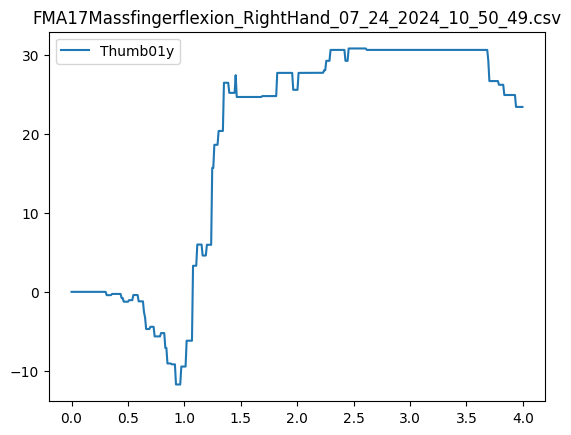

flipping Thumb01y because 289/296 > 60%


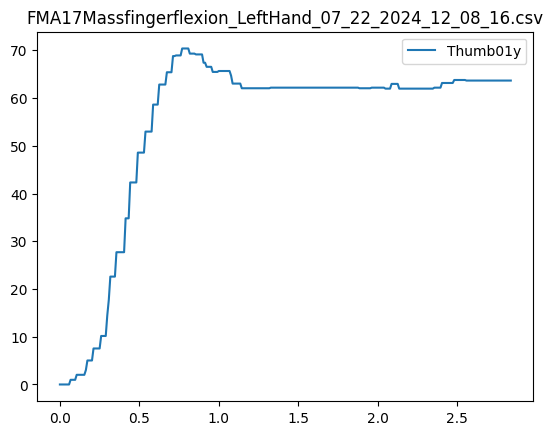

In [ ]:
example_files = ['FMA17Massfingerflexion_RightHand_07_24_2024_10_50_49.csv','FMA17Massfingerflexion_LeftHand_07_22_2024_12_08_16.csv']

dist_cols = ['Hand_pos—ThumbCMC_dist', 'Hand_pos—ThumbMCP_dist', 'Hand_pos—IndexMCP_dist', 'Hand_pos—IndexPIP_dist', 'ThumbMCP—IndexMCP_dist', 'ThumbMCP—IndexPIP_dist', 'IndexMCP—IndexPIP_dist', 'IndexMCP—IndexDIP_dist']
ratio_cols = ['Thumb_Hand_dist_ratio', 'Index_Hand_dist_ratio', 'Index_Thumb_dist_ratio', 'Index_Index_dist_ratio']


for example_file in example_files:
  # hand_pos to thumb_mcp / hand_pos to thumb_cmc
  #df,_,_ = compute_ratio(example_file, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
  # hand_pos to index_pip / hand_pos to index_mcp
  #df,_,_ = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
  # thumb_mcp to index_pip / thumb_mcp to index_mcp
  #df,_,_ = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
  df,_,_ = compute_ratio(example_file, 'IndexMCP', 'IndexPIP', 'IndexDIP', 'Index_Index_dist_ratio')

  #plt.plot(df['Timestamp'], df['Thumb_Hand_dist_ratio'], label='1')
  #plt.plot(df['Timestamp'], df['Index_Hand_dist_ratio'], label='2')
  #plt.plot(df['Timestamp'], df['Index_Thumb_dist_ratio'], label='3')
  smooth_data(df, 'Thumb01y')
  #plt.plot(df['Timestamp'], df['IndexMCP—IndexPIP_dist'], label='IndexMCP—IndexPIP_dist')
  #plt.plot(df['Timestamp'], df['IndexMCP—IndexDIP_dist'], label='IndexMCP—IndexDIP_dist')
  plt.plot(df['Timestamp'], df['Thumb01y'], label='Thumb01y')
  #plt.plot(df['Timestamp'], df['Index_Index_dist_ratio'], label='Index_Index_dist_ratio')
  plt.legend()
  plt.title(example_file)
  plt.show()


flipping Thumb01y because 354/397 > 60%


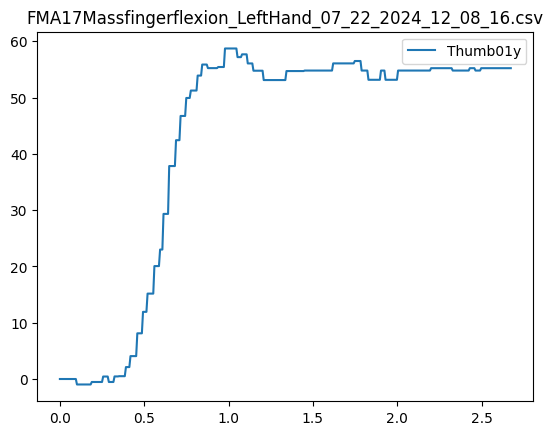

In [ ]:
folder='data/8-04-2024 and 8-05-2024 data/AK/AK_Score1_2024-08-05/'
filename = 'FMA17Massfingerflexion_LeftHand_08_05_2024_12_28_36_S1-4.csv'

df = pd.read_csv(dir+folder+filename)
smooth_data(df, 'Thumb01y')
plt.plot(df['Timestamp'], df['Thumb01y'], label='Thumb01y')

plt.legend()
plt.title(example_file)
plt.show()


In [ ]:
# grab all the csvs and divide into filenames[test#][Right/Left] dictionary
dest_folder = '/content/drive/My Drive/Bionics Lab Research/Hand Sensors_Data Processing/FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802_dist_ratios/'

import os
file_list = os.listdir(data_path)

for filename in file_list:
  # hand_pos to thumb_mcp / hand_pos to thumb_cmc
  df = compute_ratio("FMA_HANDSENSOR_DATA/ID02_PKN8M6L_EB242406061802/"+filename, 'Hand_pos_', 'ThumbCMC', 'ThumbMCP', 'Thumb_Hand_dist_ratio')
  # hand_pos to index_pip / hand_pos to index_mcp
  df = compute_ratio(df, 'Hand_pos_', 'IndexMCP', 'IndexPIP', 'Index_Hand_dist_ratio')
  # thumb_mcp to index_pip / thumb_mcp to index_mcp
  df = compute_ratio(df, 'ThumbMCP', 'IndexMCP', 'IndexPIP', 'Index_Thumb_dist_ratio')
  #write new csv
  os.makedirs(dest_folder, exist_ok=True)
  df.to_csv(dest_folder+filename, index = None)
